In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

import backwardcompatibilityml.loss as bcloss
import backwardcompatibilityml.scores as scores
from backwardcompatibilityml.helpers import utils

# Initialize random seed
random.seed(123)
torch.manual_seed(456)

%matplotlib inline

In [5]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.05
momentum = 0.5
log_interval = 10

torch.backends.cudnn.enabled = False

In [6]:
train_loader = list(torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('datasets/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True))

test_loader = list(torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('datasets/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True))

In [7]:
train_loader_a = train_loader[:int(len(train_loader)/2)]
train_loader_b = train_loader[int(len(train_loader)/2):]

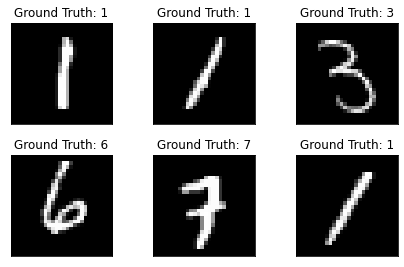

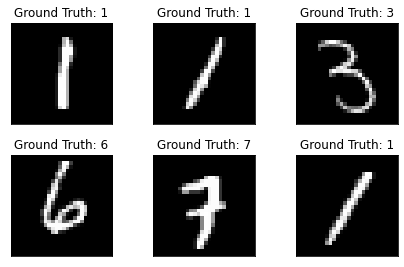

In [8]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(train_loader_a[0][0][i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(train_loader_a[0][1][i]))
    plt.xticks([])
    plt.yticks([])
fig

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x, F.softmax(x, dim=1), F.log_softmax(x, dim=1)

In [10]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [11]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader_a)*batch_size_train for i in range(n_epochs + 1)]

In [12]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader_a):
        optimizer.zero_grad()
        _, _, output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_a)*batch_size_train,
                100. * batch_idx / len(train_loader_a), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader_a)*batch_size_train))

In [13]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            _, _, output = network(data)
            test_loss += F.kl_div(output, utils.labels_to_probabilities(target, 10, batch_size_test), reduction="sum").item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(train_loader_a)*batch_size_train
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(train_loader_a)*batch_size_train,
            100. * correct / (len(train_loader_a)*batch_size_train)))

In [14]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.7645, Accuracy: 1359/30016 (5%)

Train Epoch: 1 [0/30016 (0%)]	Loss: 2.338004
Train Epoch: 1 [640/30016 (2%)]	Loss: 2.230185
Train Epoch: 1 [1280/30016 (4%)]	Loss: 2.100596
Train Epoch: 1 [1920/30016 (6%)]	Loss: 1.641219
Train Epoch: 1 [2560/30016 (9%)]	Loss: 1.448467
Train Epoch: 1 [3200/30016 (11%)]	Loss: 1.091927
Train Epoch: 1 [3840/30016 (13%)]	Loss: 0.987171
Train Epoch: 1 [4480/30016 (15%)]	Loss: 0.928289
Train Epoch: 1 [5120/30016 (17%)]	Loss: 0.659396
Train Epoch: 1 [5760/30016 (19%)]	Loss: 0.816503
Train Epoch: 1 [6400/30016 (21%)]	Loss: 0.655987
Train Epoch: 1 [7040/30016 (23%)]	Loss: 0.702386
Train Epoch: 1 [7680/30016 (26%)]	Loss: 0.863477
Train Epoch: 1 [8320/30016 (28%)]	Loss: 0.943389
Train Epoch: 1 [8960/30016 (30%)]	Loss: 0.575245
Train Epoch: 1 [9600/30016 (32%)]	Loss: 0.804478
Train Epoch: 1 [10240/30016 (34%)]	Loss: 0.473363
Train Epoch: 1 [10880/30016 (36%)]	Loss: 0.746119
Train Epoch: 1 [11520/30016 (38%)]	Loss: 0.631224
Train Epoch: 1 [12

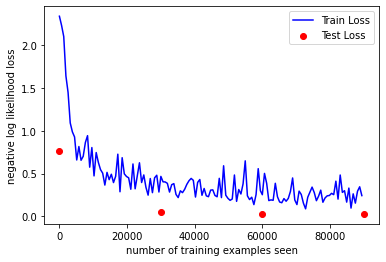

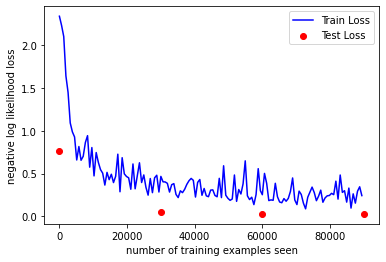

In [15]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [16]:
with torch.no_grad():
    _, _, output = network(test_loader[0][0])

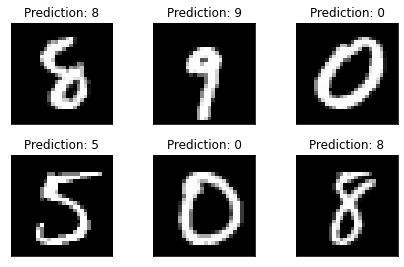

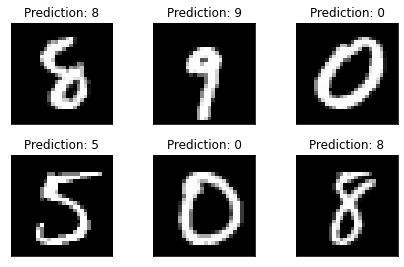

In [17]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(test_loader[0][0][i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
        output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
fig

In [18]:
import copy

h1 = copy.deepcopy(network)
h2 = copy.deepcopy(network)
h1.eval()
new_optimizer = optim.SGD(h2.parameters(), lr=learning_rate, momentum=momentum)
lambda_c = 1.0
bc_loss = bcloss.BCKLDivergenceLoss(h1, h2, lambda_c, num_classes=10)

In [19]:
update_train_losses = []
update_train_counter = []
update_test_losses = []
update_test_counter = [i*len(train_loader_b)*batch_size_train for i in range(n_epochs + 1)]

In [20]:
def train_update(epoch):
    for batch_idx, (data, target) in enumerate(train_loader_b):
        new_optimizer.zero_grad()
        loss = bc_loss(data, target)
        loss.backward()
        new_optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_b)*batch_size_train,
                100. * batch_idx / len(train_loader_b), loss.item()))
            update_train_losses.append(loss.item())
            update_train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader_b)*batch_size_train))

In [21]:
def test_update():
    h2.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            _, _, output = h2(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(train_loader_b)*batch_size_train
    update_test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(train_loader_b)*batch_size_train,
    100. * correct / (len(train_loader_b)*batch_size_train)))

In [22]:
test_update()
for epoch in range(1, n_epochs + 1):
    train_update(epoch)
    test_update()

/home/xavier/mnt/datapartition/work/virtualenvs/venv/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0295, Accuracy: 9726/30016 (32%)

Train Epoch: 1 [0/30016 (0%)]	Loss: 0.047358
Train Epoch: 1 [640/30016 (2%)]	Loss: 0.128134


/home/xavier/mnt/datapartition/work/virtualenvs/venv/lib/python3.6/site-packages/torch/nn/functional.py:2247: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Train Epoch: 1 [1280/30016 (4%)]	Loss: 0.089382
Train Epoch: 1 [1920/30016 (6%)]	Loss: 0.211169
Train Epoch: 1 [2560/30016 (9%)]	Loss: 0.077145
Train Epoch: 1 [3200/30016 (11%)]	Loss: 0.066761
Train Epoch: 1 [3840/30016 (13%)]	Loss: 0.023852
Train Epoch: 1 [4480/30016 (15%)]	Loss: 0.154534
Train Epoch: 1 [5120/30016 (17%)]	Loss: 0.053550
Train Epoch: 1 [5760/30016 (19%)]	Loss: 0.057765
Train Epoch: 1 [6400/30016 (21%)]	Loss: 0.040845
Train Epoch: 1 [7040/30016 (23%)]	Loss: 0.015508
Train Epoch: 1 [7680/30016 (26%)]	Loss: 0.037261
Train Epoch: 1 [8320/30016 (28%)]	Loss: 0.075796
Train Epoch: 1 [8960/30016 (30%)]	Loss: 0.104011
Train Epoch: 1 [9600/30016 (32%)]	Loss: 0.023155
Train Epoch: 1 [10240/30016 (34%)]	Loss: 0.022289
Train Epoch: 1 [10880/30016 (36%)]	Loss: 0.151058
Train Epoch: 1 [11520/30016 (38%)]	Loss: 0.023697
Train Epoch: 1 [12160/30016 (41%)]	Loss: 0.034754
Train Epoch: 1 [12800/30016 (43%)]	Loss: 0.060190
Train Epoch: 1 [13440/30016 (45%)]	Loss: 0.042158
Train Epoch: 1 [1

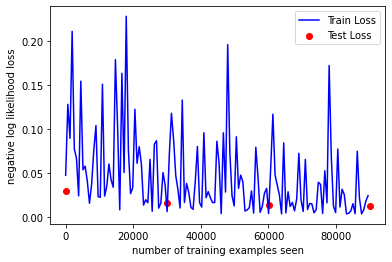

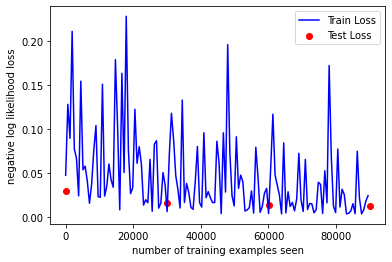

In [23]:
fig = plt.figure()
plt.plot(update_train_counter, update_train_losses, color='blue')
plt.scatter(update_test_counter, update_test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [24]:
h2.eval()
h1.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [25]:
test_index = 2

In [26]:
with torch.no_grad():
    _, _, h1_output = h1(test_loader[test_index][0])
    _, _, h2_output = h2(test_loader[test_index][0])

In [27]:
h1_labels = h1_output.data.max(1)[1]
h2_labels = h2_output.data.max(1)[1]
expected_labels = test_loader[test_index][1]

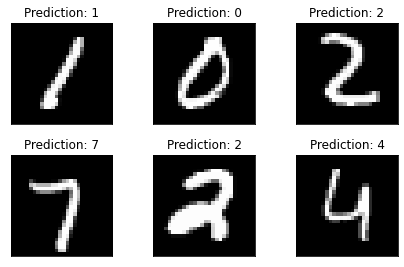

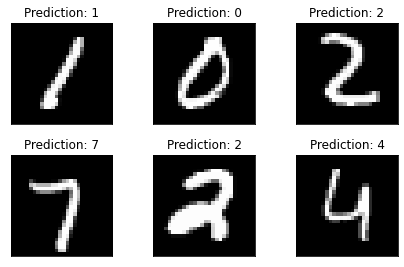

In [28]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(test_loader[test_index][0][i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
        h2_labels[i].item()))
    plt.xticks([])
    plt.yticks([])
fig

In [29]:
trust_compatibility = scores.trust_compatibility_score(h1_labels, h2_labels, expected_labels)
error_compatibility = scores.error_compatibility_score(h1_labels, h2_labels, expected_labels)

print(f"Error Compatibility Score: {error_compatibility}")
print(f"Trust Compatibility Score: {trust_compatibility}")

Error Compatibility Score: 0.3333333333333333
Trust Compatibility Score: 0.998972250770812
